In [1]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
from pyro.nn import PyroModule, PyroParam, PyroSample, pyro_method
import pyro.distributions as dist
import pyro.poutine as poutine

from modules.config import read_config
from modules.datageneration import load_data, data_functions

from tyxe_runfiles import generate
import os

from torch.utils.data import random_split, TensorDataset
from torch.utils.data.dataloader import DataLoader

import tyxe
import tyxe.util as util

import pickle

In [2]:
BASE_DIR = "./tests/underspecified"
PROFILE = "model"

In [3]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

====== Generating profile non-linear-1d-1k ======
Train: (-2, 2)
Y-space: -5.33279118005547 - 2.44630726320173
In Domain: (-2, 2)
Y-space: -5.34177646502616 - 2.5189897426265793
Out Domain: (-4, 4)
Y-space: -11.621171129536249 - 8.498793987886877


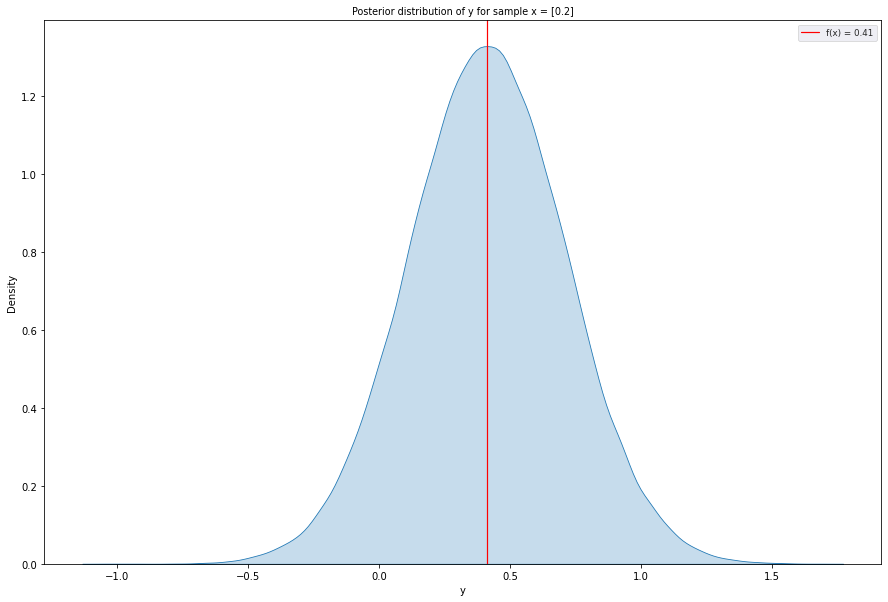

In [4]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [5]:
(x_train, y_train), _, (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)
x_test = torch.vstack((x_test_in_domain, x_test_out_domain))
y_test = torch.vstack((y_test_in_domain, y_test_out_domain))
print(x_test.shape, y_test.shape)

torch.Size([2000, 1]) torch.Size([2000, 1])


In [6]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([1000, 1]) torch.Size([1000, 1])
torch.Size([2000, 1]) torch.Size([2000, 1])


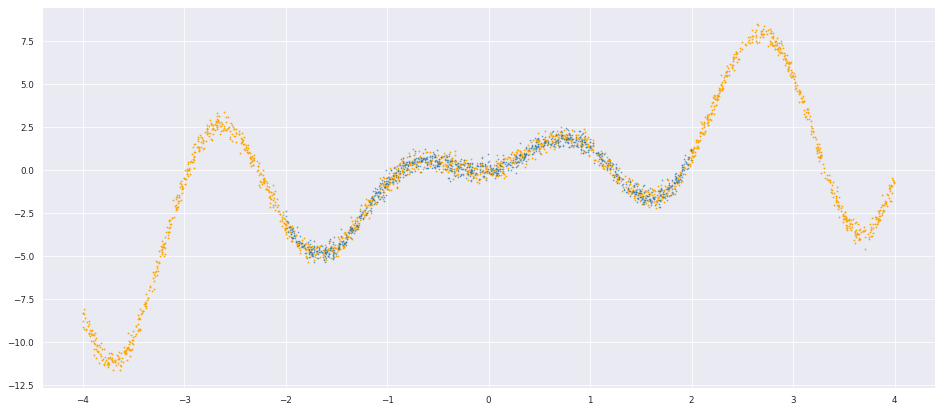

In [7]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test.squeeze(), y_test, color="orange", s=1)
plt.scatter(x_train.squeeze(), y_train, s=1, alpha=0.5)


In [8]:
train_dataset = TensorDataset(x_train, y_train)

train_dataloader = DataLoader(train_dataset, batch_size=512)

In [9]:
"""SVI"""

'SVI'

In [10]:
net = nn.Sequential(nn.Linear(1, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 1))
#net = nn.Linear(1, 1)
prior = tyxe.priors.IIDPrior(dist.Normal(1, 1))

#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=dist.Gamma(1.0, 1.0))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=torch.tensor(0.1))
#likelihood_guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
likelihood_guide_builder = None

guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
bnn = tyxe.bnn.VariationalBNN(net, prior, obs_model, guide_builder, likelihood_guide_builder=likelihood_guide_builder)

In [11]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-4})
elbos = []
def callback(bnn, i, e):
    if i % 100 == 0:
        print("epoch: {} | elbo: {}".format(i, e))
    elbos.append(e)

with tyxe.poutine.flipout():
    bnn.fit(train_dataloader, optim, 10000, callback)

epoch: 0 | elbo: 1828979456.0
epoch: 100 | elbo: 1688857024.0
epoch: 200 | elbo: 1560250944.0
epoch: 300 | elbo: 1442585088.0
epoch: 400 | elbo: 1334102656.0
epoch: 500 | elbo: 1233815168.0
epoch: 600 | elbo: 1141761600.0
epoch: 700 | elbo: 1056300512.0
epoch: 800 | elbo: 977719520.0
epoch: 900 | elbo: 904376032.0
epoch: 1000 | elbo: 836790624.0
epoch: 1100 | elbo: 773734880.0
epoch: 1200 | elbo: 715216960.0
epoch: 1300 | elbo: 660763872.0
epoch: 1400 | elbo: 610164992.0
epoch: 1500 | elbo: 563033152.0
epoch: 1600 | elbo: 519213120.0
epoch: 1700 | elbo: 478514864.0
epoch: 1800 | elbo: 440492592.0
epoch: 1900 | elbo: 405173664.0
epoch: 2000 | elbo: 372155184.0
epoch: 2100 | elbo: 341615360.0
epoch: 2200 | elbo: 313033152.0
epoch: 2300 | elbo: 286347168.0
epoch: 2400 | elbo: 261741544.0
epoch: 2500 | elbo: 238886504.0
epoch: 2600 | elbo: 217447080.0
epoch: 2700 | elbo: 197605504.0
epoch: 2800 | elbo: 179222016.0
epoch: 2900 | elbo: 162235728.0
epoch: 3000 | elbo: 146411896.0
epoch: 3100 

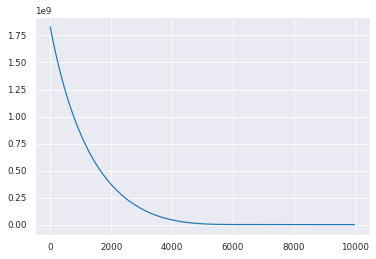

In [12]:
plt.plot(elbos)

In [13]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)
print(preds[0].shape, preds[1].shape)
print(preds[0][:4], preds[1][:4])

means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

torch.Size([2000, 1]) torch.Size([2000, 1])
tensor([[-5.3546],
        [-5.3535],
        [-5.3529],
        [-5.3516]]) tensor([[0.1000],
        [0.1000],
        [0.1000],
        [0.1000]])


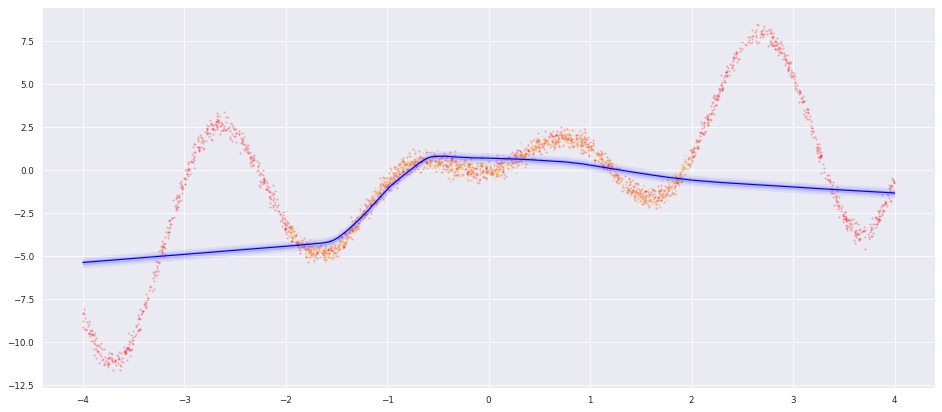

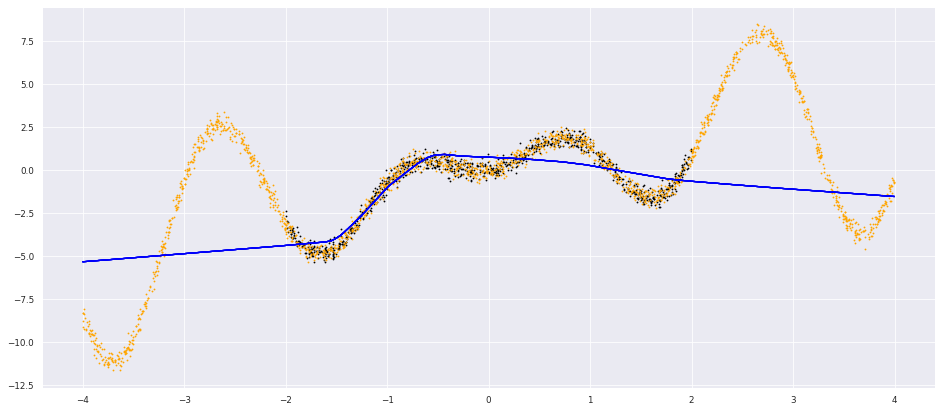

In [14]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
plt.plot(x_test[test_sort], means, color="blue")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

sampled_predictions = bnn.predict(x_test[test_sort], num_predictions=25, aggregate=False)
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_train, y_train, color="black", s=1)
plt.scatter(x_test[test_sort], y_test[test_sort], color="orange", s=1)
for yhat in sampled_predictions:
    plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)

In [15]:
raise Exception("stop here")

Exception: stop here

In [ ]:
#raise Exception("stop")

In [ ]:
"""MCMC"""

'MCMC'

In [ ]:
net = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 1))
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))

#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=PyroParam(torch.tensor(0.1), constraint=dist.constraints.positive))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=dist.Gamma(1.0, 1.0))
#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=torch.tensor(0.1))

kernel = pyro.infer.mcmc.NUTS

bnn = tyxe.MCMC_BNN(net, prior, obs_model, kernel)

In [ ]:
pyro.clear_param_store()

bnn.fit(train_dataloader, num_samples=1000, warmup_steps=1000)

Warmup:   1%|▏         | 26/2000 [00:33,  2.12s/it, step size=1.35e-03, acc. prob=0.764]

KeyboardInterrupt: 

In [ ]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)

means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

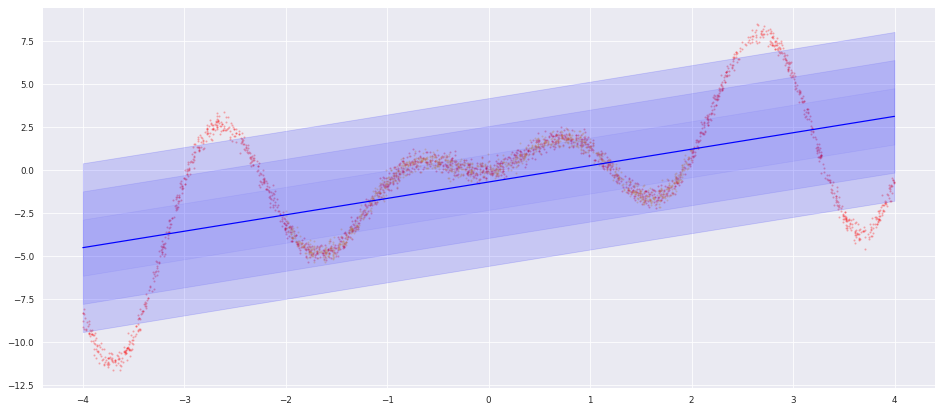

In [ ]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
plt.plot(x_test[test_sort], means, color="blue")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=c/2 * 0.1, color="blue")

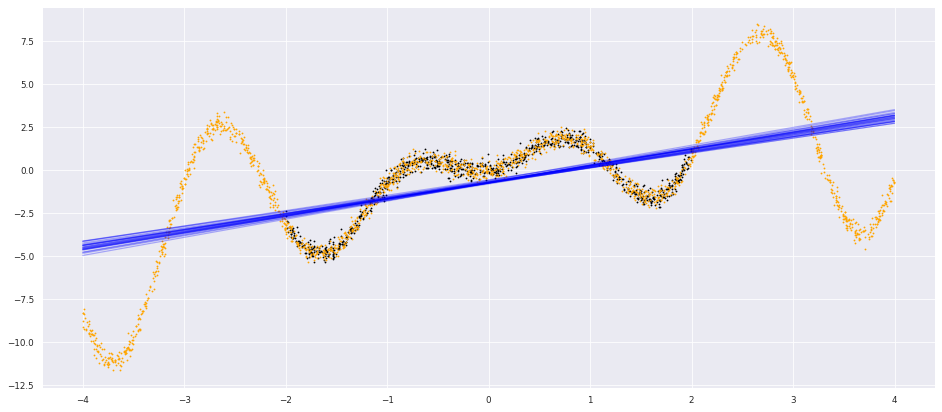

In [ ]:
sampled_predictions = bnn.predict(x_test[test_sort], num_predictions=25, aggregate=False)
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_train, y_train, color="black", s=1)
plt.scatter(x_test[test_sort], y_test[test_sort], color="orange", s=1)
for yhat in sampled_predictions:
    plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)